In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
import warnings
import missingno as msno

In [2]:
loan_dataframe = pd.read_csv('Loan_Default.csv')

In [3]:
loan_dataframe.shape

(148670, 34)

Dataset Features:
* loan_limit (cf: conforming loan, ncf: non conforming loan) 
    -  A conforming loan is a mortgage that meets the dollar limits set by the Federal Housing Finance Agency (FHFA) and the funding criteria of Freddie Mac and Fannie Mae. In 2019 baseline loan limit was 484350$.
    - Mortgages that exceed the conforming loan limit are classified as nonconforming or jumbo mortgages.
* Gender (Male, Female, Not Availabe, Joint)
* approv_in_adv (pre, nopre): pre-approval is a preliminary evaluation of a potential borrower by a lender to determine whether they are likely to be approved for a loan
* loan_type (type1, type2, type3)
* loan_purpose (p1, p2, p3, p4)
* Credit_Worthiness(l1, l2):
    - L1 (Level 1): This typically represents the highest level of creditworthiness. Individuals or entities categorized under L1 are considered to have excellent credit histories
    - L2 (Level 2): This represents the next tier of creditworthiness, which is generally good but not as strong as L1. Individuals or entities categorized under L2 may have a good credit history with a few minor issues, such as occasional late payments or higher credit utilization
* open_credit (opc/nopc): Open credit is a pre-approved loan between a lender and a borrower. It allows the borrower to make repeated withdrawals up to a certain limit and then make subsequent repayments before the payments become due.
* business_or_commercial: b\c - business or commercial loan, nob\c - not a business or commercial loan  
* loan_amount
* rate_of_interest
* interest_rate_spread: the interest rate charged by banks on loans to private sector customers minus the interest rate paid by commercial or similar banks for demand, time, or savings deposits
* Upfront_charges
* term: The loan term in months (e.g., 360.0 for a 30-year mortgage).
* Neg_ammortization: Indicates whether the loan has negative amortization, e.g., "not_neg" (no negative amortization).
* interest_only: Indicates whether the loan is interest-only, e.g., "not_int" (not interest-only).
* lump_sum_payment: Indicates if a lump sum payment has been made, e.g., "not_lpsm" (no lump sum payment), "lpsm" (lump sum payment made).
* property_value: The value of the property being financed.
* construction_type: The type of construction, e.g., "sb" (site-built).
* occupancy_type: The occupancy type of the property, e.g., "pr" (primary residence), "sec" (secondary residence).
* Secured_by: What the loan is secured by, e.g., "home" (secured by home).
* total_units: The number of units in the property (e.g., "1U" for a single-unit property).
* income: The borrower's income.
* credit_type: The credit bureau providing the credit score, e.g., "EXP" (Experian), "EQUI" (Equifax), "CRIF" (CRIF High Mark).
* Credit_Score: The borrower's credit score.
* co-applicant_credit_type: The credit bureau providing the co-applicant's credit score, e.g., "CIB" (CIBIL).
* age: Age group of the primary applicant, e.g., "25-34," "35-44," etc.
* submission_of_application: How the loan application was submitted, e.g., "to_inst" (through institution), "not_inst" (not through institution).
* Region: Geographic region where the loan was issued, e.g., "north," "south."
* Security_Type: Type of security, e.g., "direct."
* dtir1 - percentage of gross monthly income that is used to pay monthly debt
* LTV - relative difference between the loan amount and the current market value of a home (the property_value)


In [4]:
pd.set_option('display.max_columns', None)
loan_dataframe.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [5]:
loan_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [6]:
#changing total_units column froma categorical to numerical by removing 'U' suffix and chaning type to int
loan_dataframe['total_units'] = loan_dataframe['total_units'].str.replace('U','').astype(int)

In [7]:
loan_dataframe.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,total_units,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,148670.000000,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,1.021679,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,0.198521,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,1.000000,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,1.000000,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,1.000000,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,1.000000,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,4.000000,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [8]:
loan_dataframe.describe(exclude=[np.number])

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,Neg_ammortization,interest_only,lump_sum_payment,construction_type,occupancy_type,Secured_by,credit_type,co-applicant_credit_type,age,submission_of_application,Region,Security_Type
count,145326,148670,147762,148670,148536,148670,148670,148670,148549,148670,148670,148670,148670,148670,148670,148670,148470,148470,148670,148670
unique,2,4,2,3,4,2,2,2,2,2,2,2,3,2,4,2,7,2,4,2
top,cf,Male,nopre,type1,p3,l1,nopc,nob/c,not_neg,not_int,not_lpsm,sb,pr,home,CIB,CIB,45-54,to_inst,North,direct
freq,135348,42346,124621,113173,55934,142344,148114,127908,133420,141560,145286,148637,138201,148637,48152,74392,34720,95814,74722,148637


In [9]:
loan_dataframe.isna().sum()

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [10]:
missing_percentage = pd.DataFrame(loan_dataframe.isna().sum()/len(loan_dataframe)*100).reset_index()
missing_percentage.columns = ['Feature', '%'+' of missing data']
missing_percentage.sort_values(by=['%'+' of missing data'], ascending=False)[:15]

,Feature,% of missing data
13,Upfront_charges,26.664425
12,Interest_rate_spread,24.644515
11,rate_of_interest,24.509989
33,dtir1,16.224524
29,LTV,10.155378
18,property_value,10.155378
23,income,6.154571
2,loan_limit,2.249277
4,approv_in_adv,0.610749
28,submission_of_application,0.134526


In dataset there is 14 columns with missing variables, in 7 of them there are between 6% and 26% of missing values

We can drop ID and year columns, as they will not be useful for data analysis and modelling. Also Upfront_charges is administrative charge, that would not have impact on analysis and prediction

In [11]:
loan_dataframe = loan_dataframe.drop(['ID', 'year', 'Upfront_charges'], axis=1)

Lets investigate pattern of data missingness.

<Axes: >

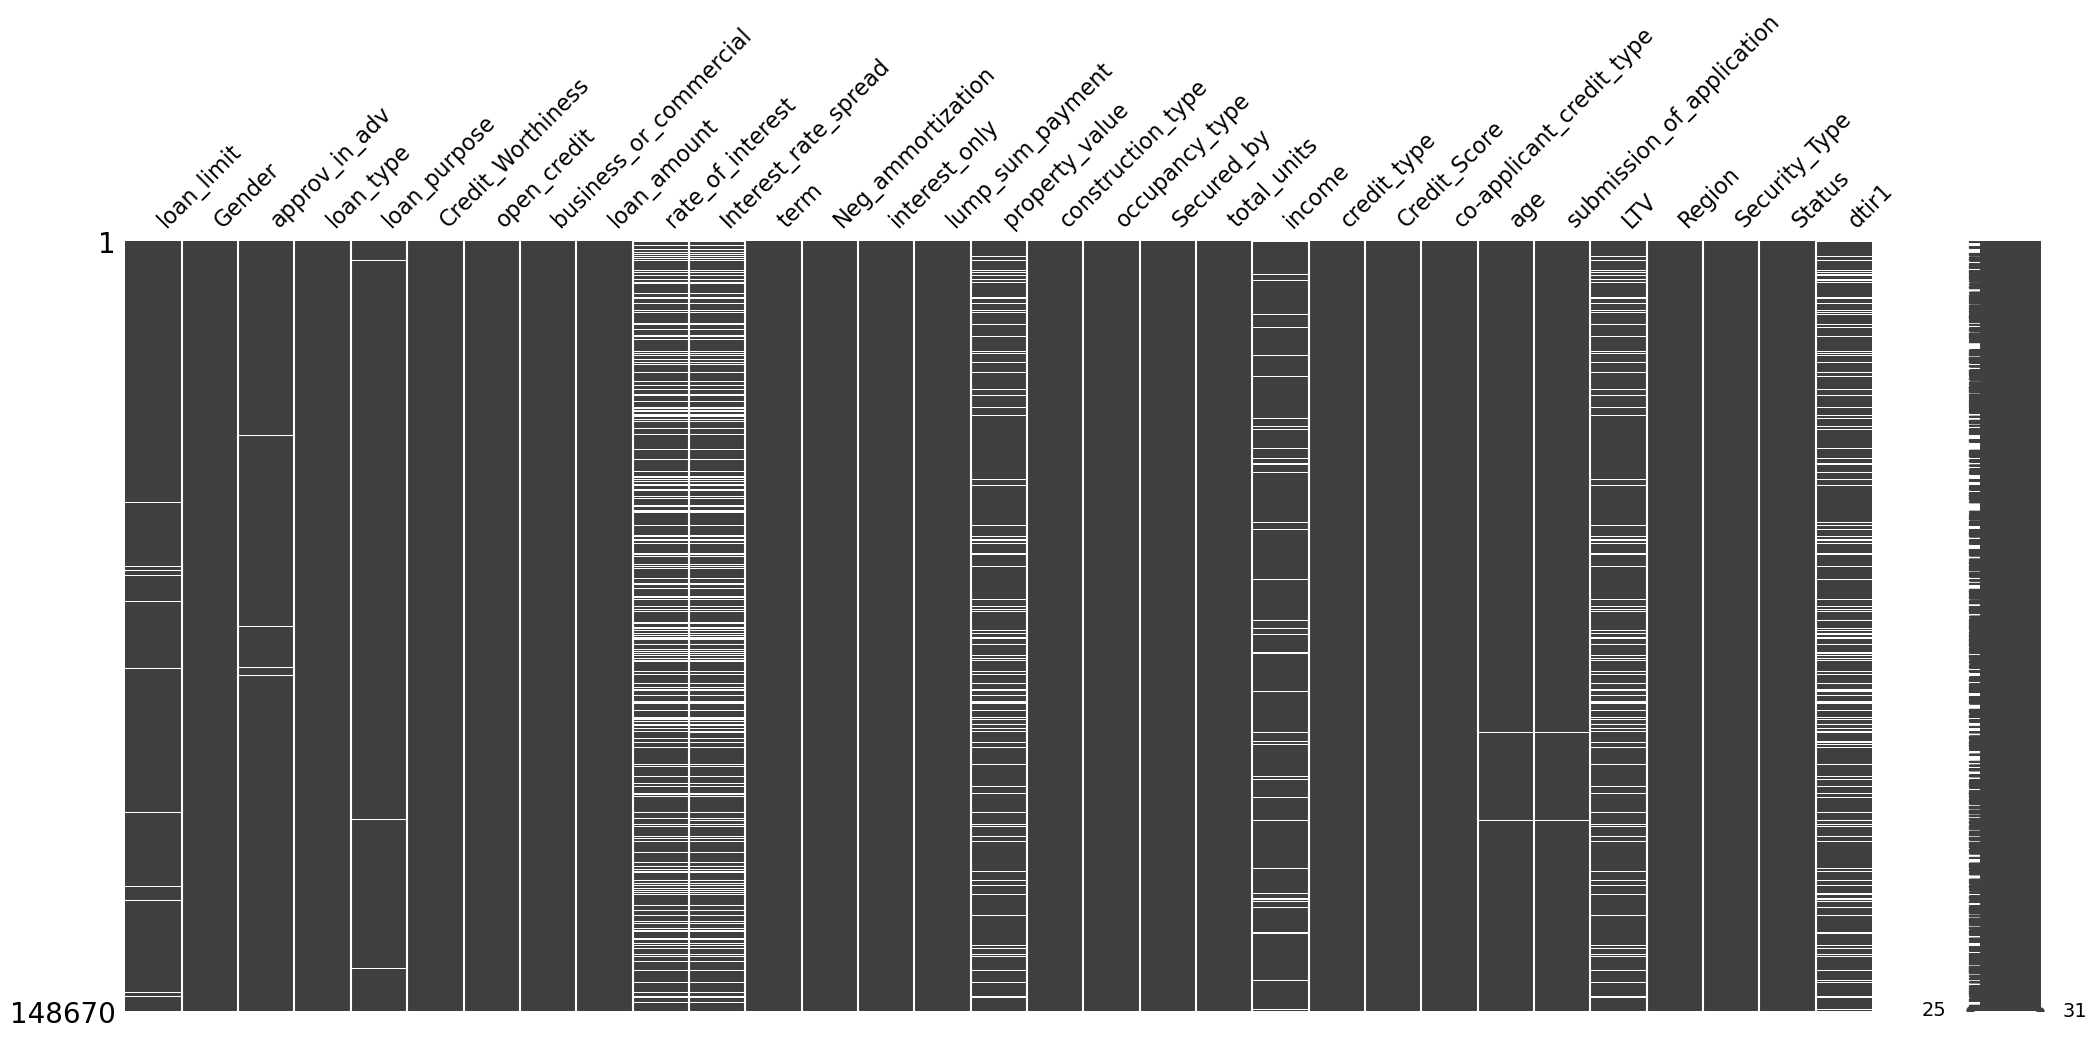

In [12]:
msno.matrix(loan_dataframe)

<Axes: >

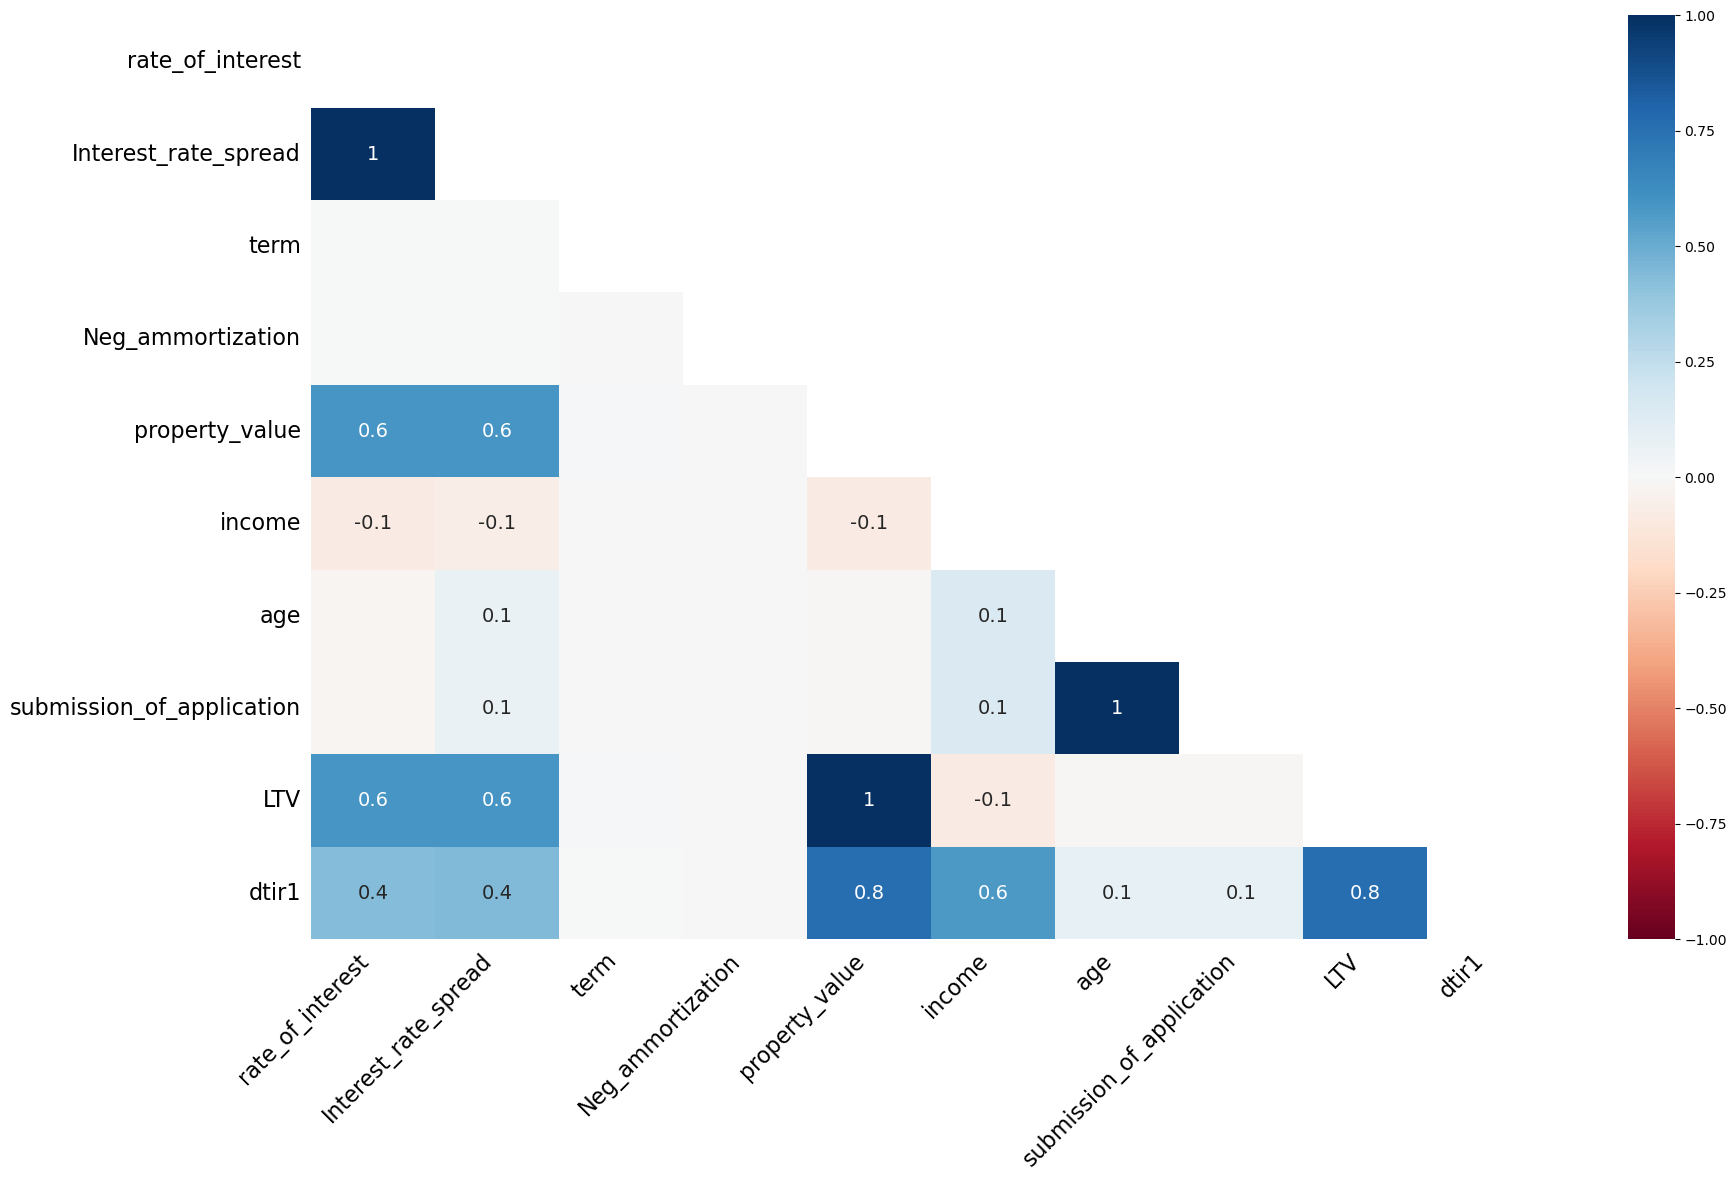

In [13]:
msno.heatmap(loan_dataframe.loc[:, ~loan_dataframe.columns.isin(['loan_limit', 'approv_in_adv', 'loan_purpose'])])

On the missingness of data correlation matrix we can observe some high correlation between certain columns. Based on that we conclude that data are not MCAR (Missing Completly At Random), we assume, that data are MAR (Missing At Random).

The loan_limit, approv_in_adv, submission_of_application, age, loan_purpose, Neg_ammortization, term columns contain small amount of missin data (below 3%) hence rows containing missing data in these columns will be dropped.

In [14]:
loan_df_drop = loan_dataframe.dropna(subset=['loan_limit', 'approv_in_adv', 'submission_of_application', 'age', 'loan_purpose', 'Neg_ammortization', 'term'])
loan_df_drop.shape

(143942, 31)

In [15]:
(148670-143942)/148670

0.03180197753413601

3% of data were dropped 

Number of missing data after deletion:

In [16]:
loan_df_drop.isna().sum().sum()

131843

In [17]:
missing_cols = loan_df_drop.columns[loan_df_drop.isna().any()].tolist()
missing_cols

['rate_of_interest',
 'Interest_rate_spread',
 'property_value',
 'income',
 'LTV',
 'dtir1']

Other columns contain significant amount of missing data, because of that, rows with missing data can't ber dropped.
Missing data will be imputed using KNN Imputation.

In [18]:
numerical_columns = loan_df_drop.select_dtypes(include=[np.number]).columns.to_list()
categorical_columns = loan_df_drop.select_dtypes(include=['object']).columns.tolist()

In [19]:
numerical_columns

['loan_amount',
 'rate_of_interest',
 'Interest_rate_spread',
 'term',
 'property_value',
 'total_units',
 'income',
 'Credit_Score',
 'LTV',
 'Status',
 'dtir1']

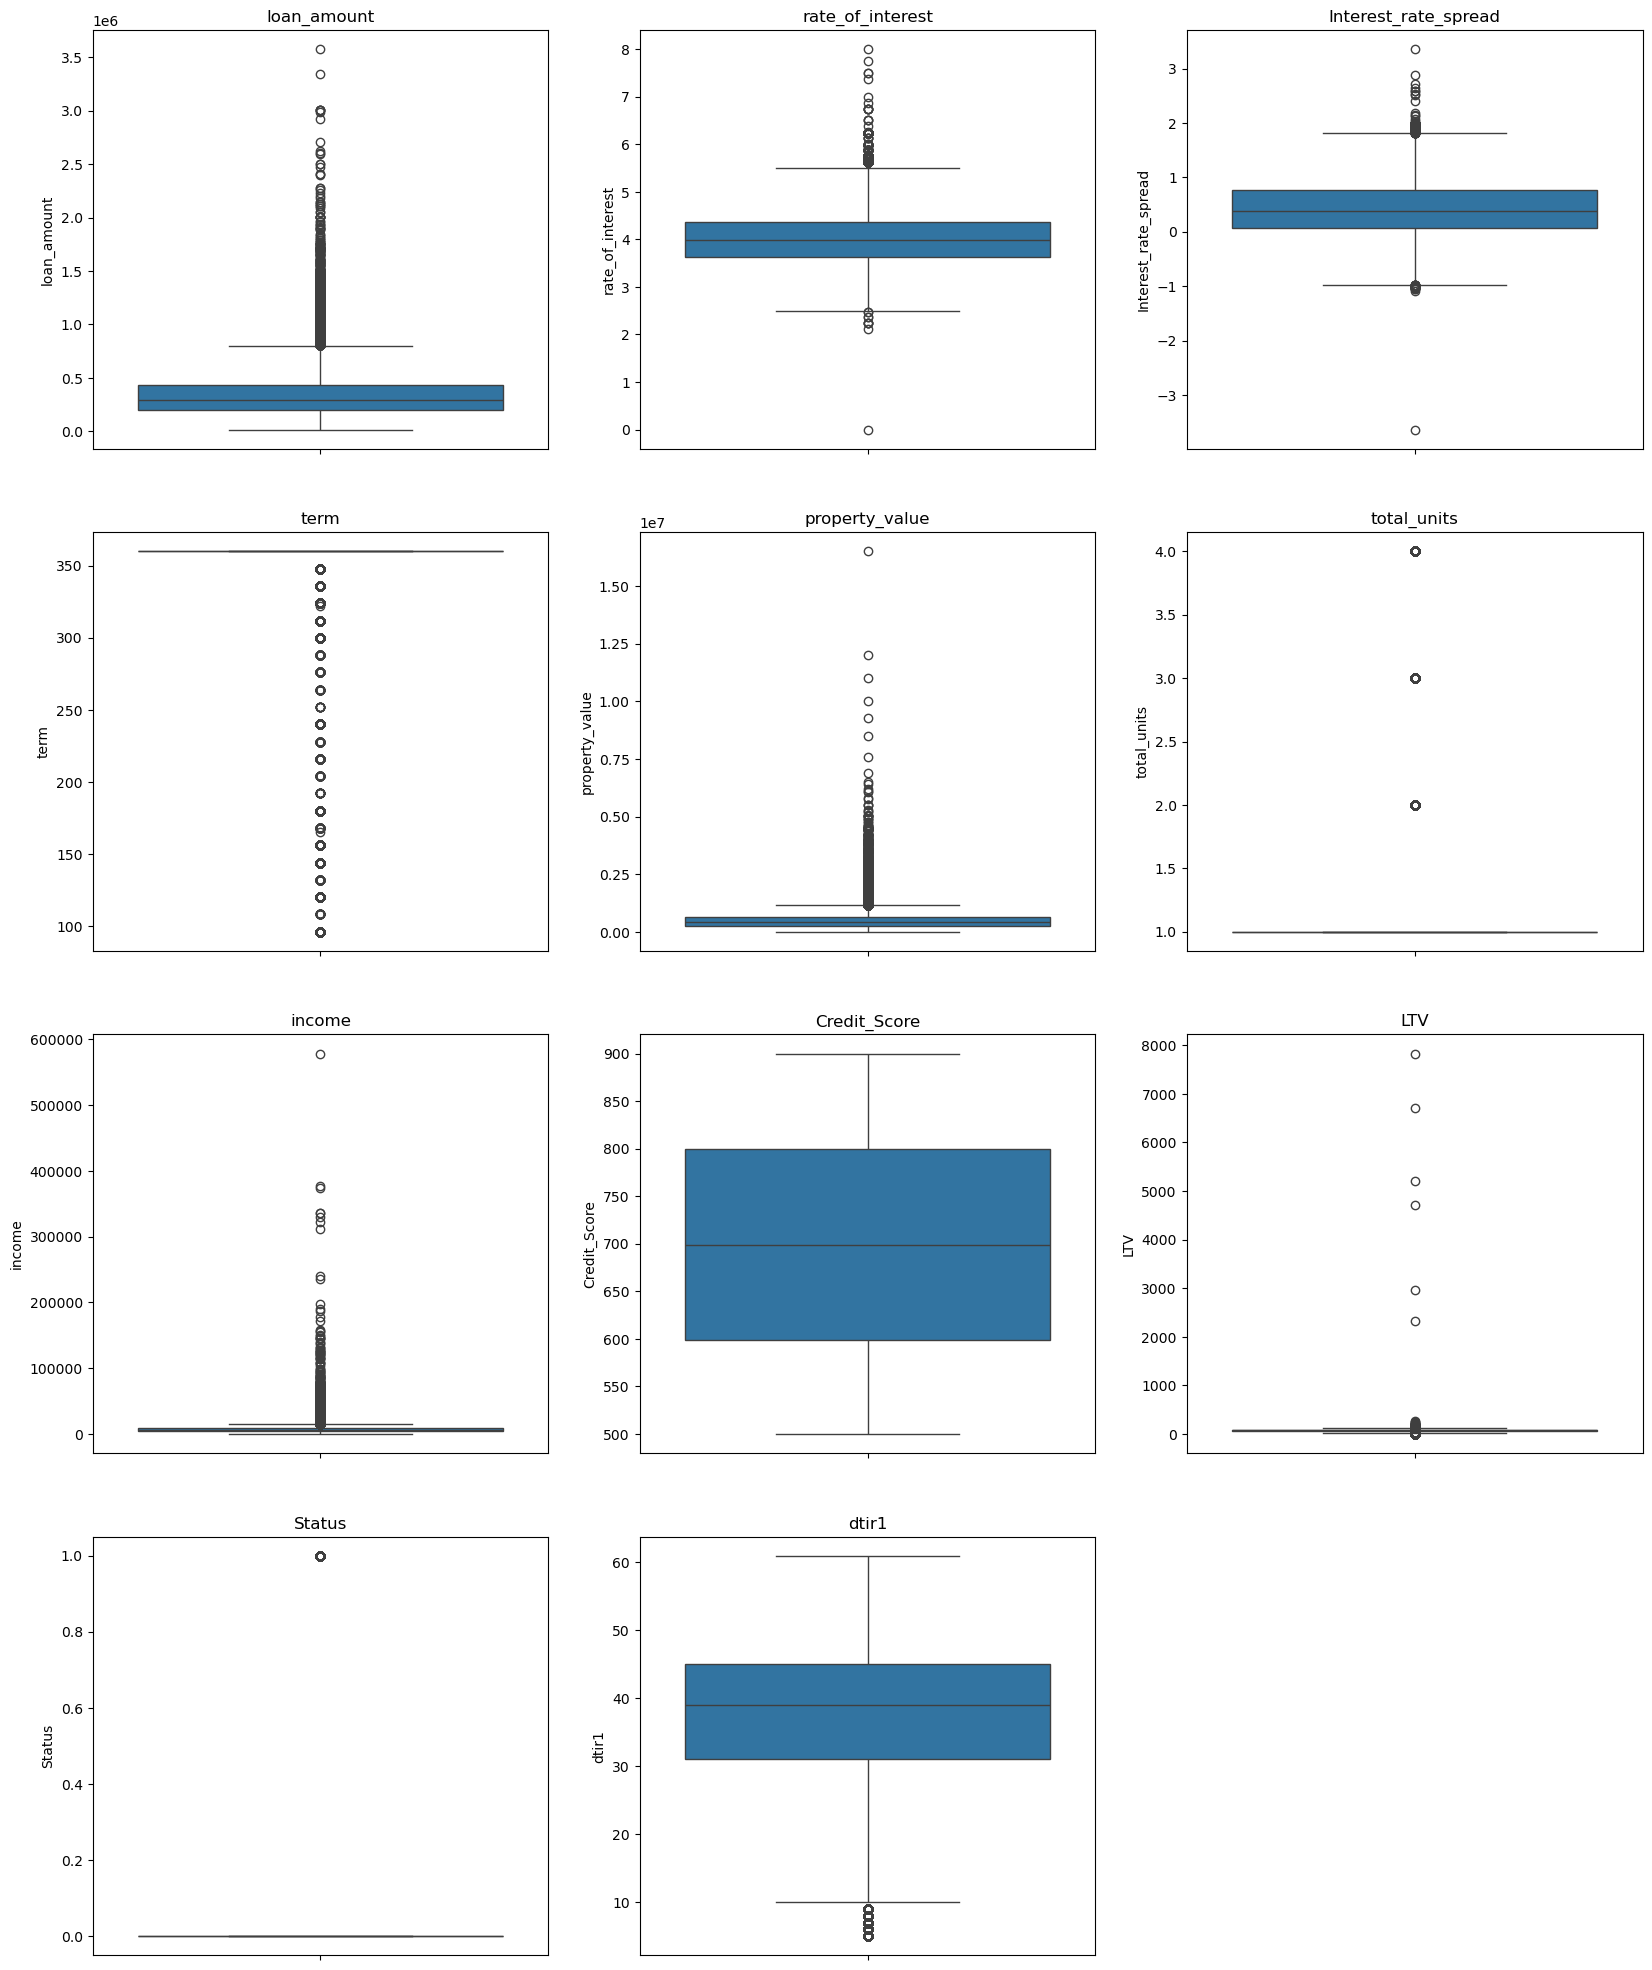

In [22]:
plt.figure(figsize=(20,25))

for i, col in enumerate(numerical_columns):
    plt.subplot(4,3,i+1)
    sns.boxplot(data=loan_df_drop[col]).set_title(col) 

The numerical features in our dataset contain a considerable number of outliers, which do not appear to be errors. Therefore, it could be beneficial to retain these outliers for imputation, analysis, and model fitting. We will use KNNImputer to handle missing data. To effectively perform KNN imputation, an appropriate scaler must be used. For data with outliers, Robust Scaler is considered one of the best options. Categorical variables would be transformed using one-hot encoding.

In [23]:
oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
sc = RobustScaler()
encoded = oh.fit_transform(loan_df_drop[categorical_columns])
scaled = pd.DataFrame(sc.fit_transform(loan_df_drop[numerical_columns]), columns = numerical_columns)
df_enc_scal = pd.concat([encoded, scaled], axis=1)

In [24]:
def invert_preprocessor(df, oh=oh, sc=sc, num_columns = numerical_columns, org_cat_columns = categorical_columns):
    cat_columns = oh.get_feature_names_out(categorical_columns).tolist()
    decoded = pd.DataFrame(oh.inverse_transform(df[cat_columns]), columns=org_cat_columns)
    descaled = pd.DataFrame(sc.inverse_transform(df[num_columns]), columns=num_columns)
    decoded = decoded.reset_index(drop=True)
    descaled = descaled.reset_index(drop=True)
    return pd.concat([decoded, descaled], axis=1)

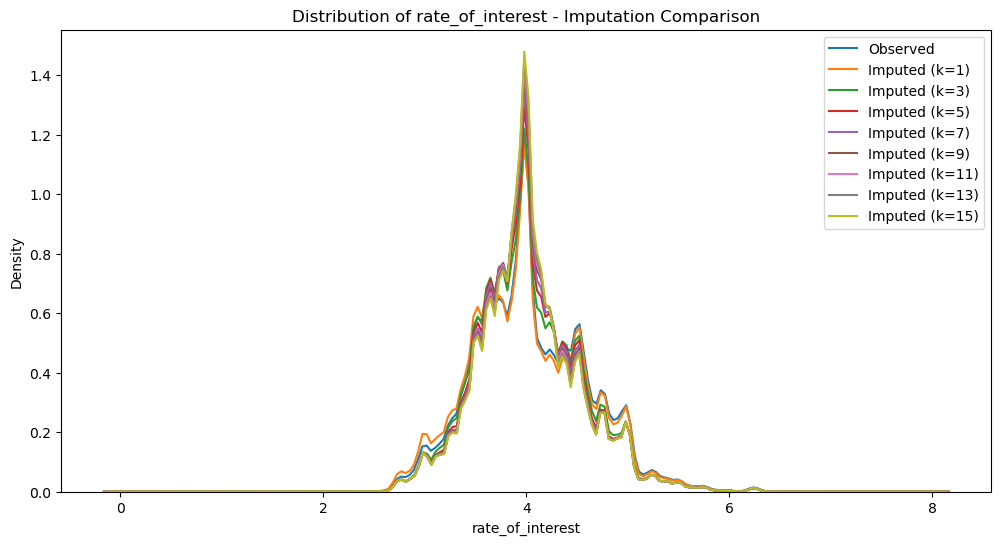

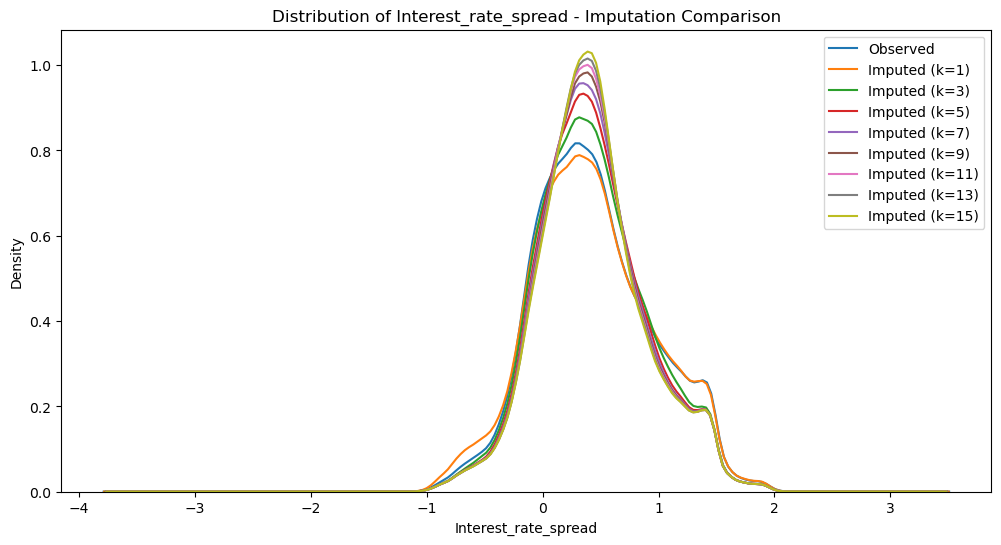

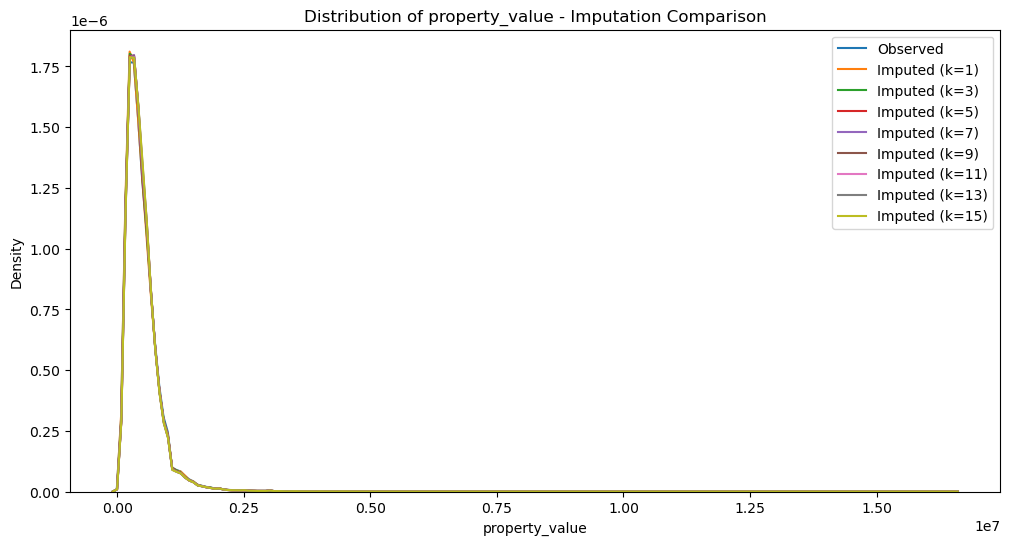

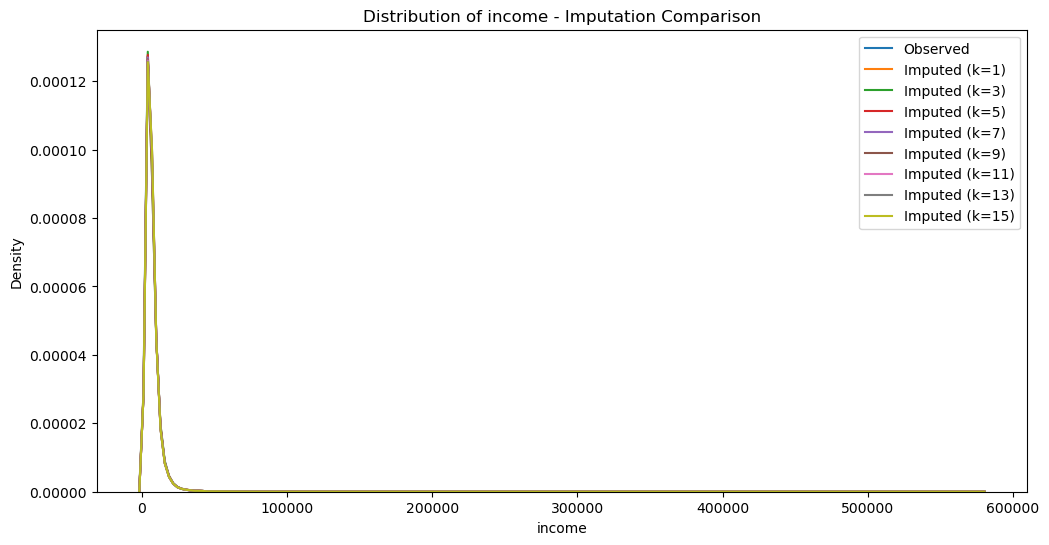

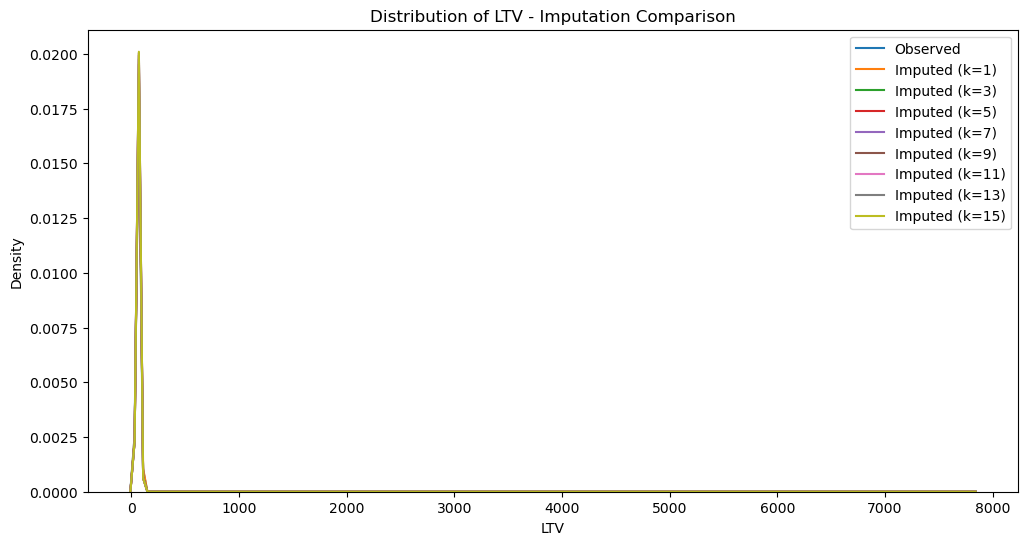

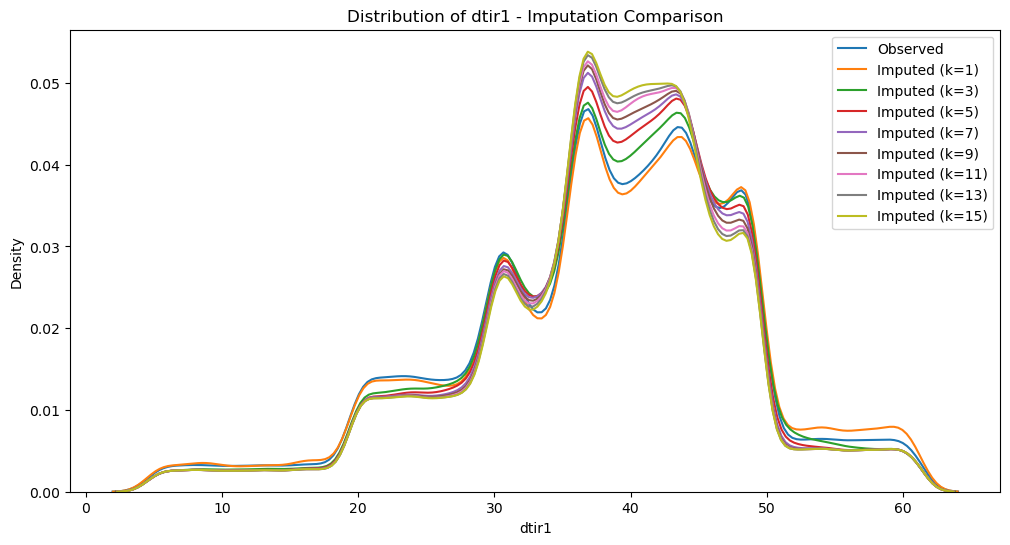

In [26]:
n_neighbors_range = range(1, 17, 2)
inverted_df_list = []

for k in n_neighbors_range:
    # Impute missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=k)
    imputed_data = imputer.fit_transform(df_enc_scal)
    
    # Create DataFrame from imputed data
    imputed_df = pd.DataFrame(imputed_data, columns=df_enc_scal.columns)

    # Store inverted DataFrame
    inverted_df_list.append(invert_preprocessor(imputed_df))

# Plot density comparison for each column and each parameter k
for column in missing_cols:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(loan_dataframe[column].dropna(), label='Observed', fill=False)
    for i, k in enumerate(n_neighbors_range):
        sns.kdeplot(inverted_df_list[i][column], label=f'Imputed (k={k})', fill=False)
    plt.title(f'Distribution of {column} - Imputation Comparison')
    plt.legend()
    plt.show()
 
    

Distributions of imputed columns are close to each other and are similar to distributions of columns without imputation.

### Determining the Optimal Number of Neighbors for KNN Imputation

To determine the optimal number of neighbors for KNN imputation, we will employ the following methodology:

1. **Creating a Mask**: Randomly select a subset of the non-missing values in the dataset and temporarily replace them with NaN values.
2. **Imputation**: Perform KNN imputation on the dataset with the introduced NaN values using various numbers of neighbors.
3. **Evaluation**: Compare the imputed values to the original, non-missing values to assess the accuracy of the imputation.
4. **Selection**: Identify the number of neighbors that results in the most accurate impudataset.


In [36]:
data = df_enc_scal.copy()
data = data.sample(frac=0.3, replace=False, random_state=12)

# Create a mask to select additional non-null values to be set to NaN in numerical columns
num_non_null_to_mask = int(data[numerical_columns].notna().sum().sum() * 0.1)
non_null_indices = np.argwhere(data[numerical_columns].notna().values)

# Randomly select indices to mask
np.random.seed(0)
masked_indices = non_null_indices[np.random.choice(non_null_indices.shape[0], num_non_null_to_mask, replace=False)]

# Store original values that will be masked
original_values = data.values[masked_indices[:, 0], len(categorical_columns) + masked_indices[:, 1]]

# Mask the selected values
masked_data = data.copy()
masked_data.values[masked_indices[:, 0], len(categorical_columns) + masked_indices[:, 1]] = np.nan

# Apply KNN imputation and evaluate
k_values = range(1, 18, 2)
results = []

for k in k_values:
    imputer = KNNImputer(n_neighbors=k)
    imputed_data = imputer.fit_transform(masked_data)
    
    # Get imputed values for masked positions
    imputed_values = imputed_data[masked_indices[:, 0], len(categorical_columns) + masked_indices[:, 1]]
    
    # Calculate RMSE for the masked values
    rmse = root_mean_squared_error(original_values, imputed_values)
    
    results.append({'k': k, 'RMSE': rmse})

# Display results
results_df = pd.DataFrame(results)
print(results_df)

    k      RMSE
0   1  0.184388
1   3  0.159641
2   5  0.155894
3   7  0.154751
4   9  0.153876
5  11  0.153753
6  13  0.153606
7  15  0.153724
8  17  0.153808


RMSE is lowest for k = 13

The KNNImputer wi n_neighbors parameter =13 will be fitted on whole dataset

In [205]:
final_imputer = KNNImputer(n_neighbors=13)
imputed_dataset = final_imputer.fit_transform(df_enc_scal)

In [206]:
df_imputed = pd.DataFrame(imputed_dataset, columns = oh.get_feature_names_out(categorical_columns).tolist() + numerical_columns)

In [207]:
df_fin = invert_preprocessor(df_imputed)

In [212]:
df_fin.to_csv('Loan_Default_imputed.csv', index=False)

# Exploratory Data Analysis

Lets look at target variable. Loan status is skewed with majority of non-default.

In [25]:
df_fin = pd.read_csv('Loan_Default_imputed.csv')

In [36]:
df_fin.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,Neg_ammortization,interest_only,lump_sum_payment,construction_type,occupancy_type,Secured_by,credit_type,co-applicant_credit_type,age,submission_of_application,Region,Security_Type,loan_amount,rate_of_interest,Interest_rate_spread,term,property_value,total_units,income,Credit_Score,LTV,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,not_neg,not_int,not_lpsm,sb,pr,home,EXP,CIB,25-34,to_inst,south,direct,116500.0,4.199231,0.522692,360.0,118000.000000,1.0,1740.0,758.0,98.728814,1.0,45.000000
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,not_neg,not_int,lpsm,sb,pr,home,EQUI,EXP,55-64,to_inst,North,direct,206500.0,3.940000,1.006962,360.0,228769.230769,1.0,4980.0,552.0,87.282005,1.0,43.615385
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,neg_amm,not_int,not_lpsm,sb,pr,home,EXP,CIB,35-44,to_inst,south,direct,406500.0,4.560000,0.200000,360.0,508000.000000,1.0,9480.0,834.0,80.019685,0.0,46.000000
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,not_neg,not_int,not_lpsm,sb,pr,home,EXP,CIB,45-54,not_inst,North,direct,456500.0,4.250000,0.681000,360.0,658000.000000,1.0,11880.0,587.0,69.376900,0.0,42.000000
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,not_neg,not_int,not_lpsm,sb,pr,home,CRIF,EXP,25-34,not_inst,North,direct,696500.0,4.000000,0.304200,360.0,758000.000000,1.0,10440.0,602.0,91.886544,0.0,39.000000


<Axes: xlabel='Status', ylabel='count'>

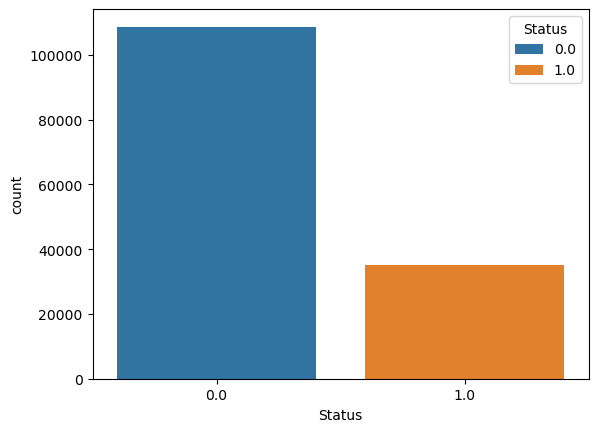

In [27]:
sns.countplot(df_fin, x='Status', hue='Status')

In [28]:
import warnings
warnings.filterwarnings('ignore')

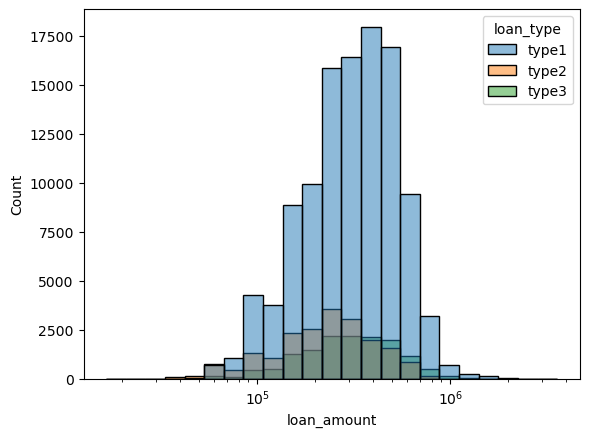

In [29]:
sns.histplot(df_fin, x='loan_amount', hue='loan_type',binwidth = 0.1, log_scale=True);

Above chart indicates the loan amount, count of loans, taken and their types. Most popular type of loan is type1.

Boxplot below explains loan amount sanctioned based on the gender and it has been differented based on the credit worthiness

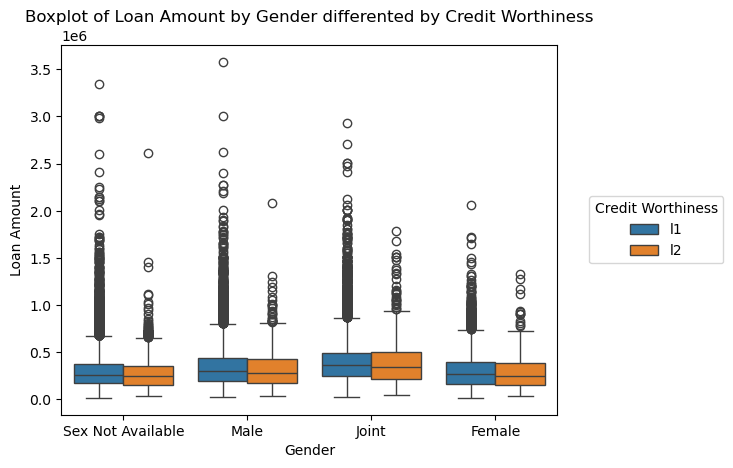

In [30]:
sns.boxplot(data=df_fin, x="Gender", y="loan_amount", hue="Credit_Worthiness")
plt.title('Boxplot of Loan Amount by Gender differented by Credit Worthiness')
plt.xlabel('Gender')
plt.ylabel('Loan Amount')
plt.legend(title='Credit Worthiness', bbox_to_anchor=(1.05, 0.5), loc='center left');

Boxplot below explains loan amount sanctioned based on the credit type and it has been differented based on the credit worthiness.

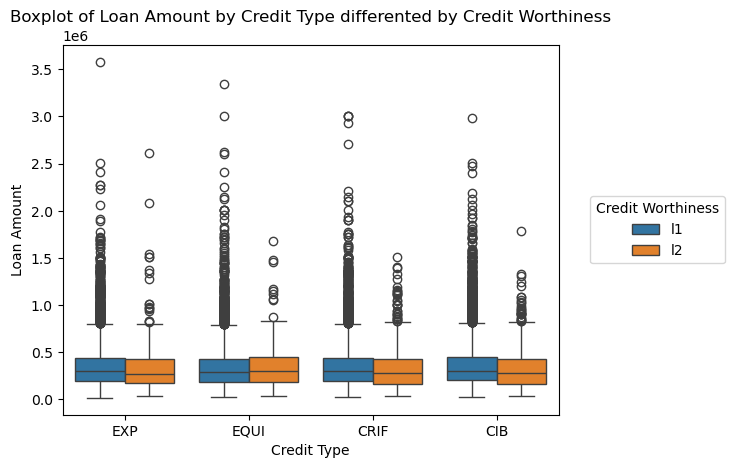

In [31]:
sns.boxplot(data=df_fin, x="credit_type", y="loan_amount", hue="Credit_Worthiness")
plt.title('Boxplot of Loan Amount by Credit Type differented by Credit Worthiness')
plt.xlabel('Credit Type')
plt.ylabel('Loan Amount')

plt.legend(title='Credit Worthiness', bbox_to_anchor=(1.05, 0.5), loc='center left');

For each type of credit there is 
specific range of loan amount being allotte.d

The following histogram helps us understand the credit type and how much rate of interest is provided for each credit type and what is frequency for it. From the below chart it can be observed that CIB has the highest frequency with the rate of interest between 2% and 6% where as the lowest includes the EQUI credit type with less frequency and rate of interest between 3% and 5%.

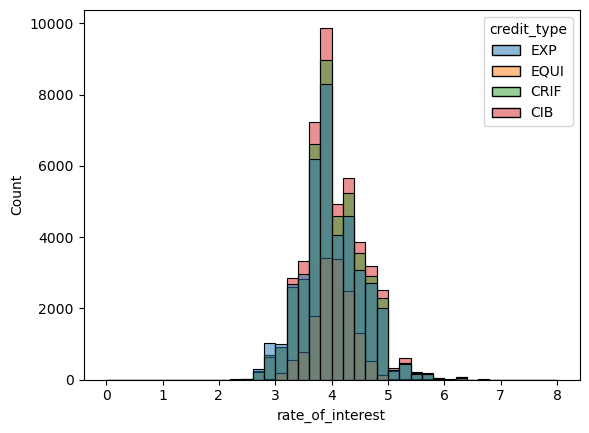

In [46]:
sns.histplot(df_fin, x='rate_of_interest', hue='credit_type',binwidth = 0.2);

Quick summary of categorical variables in respect to target variable 'Status'.

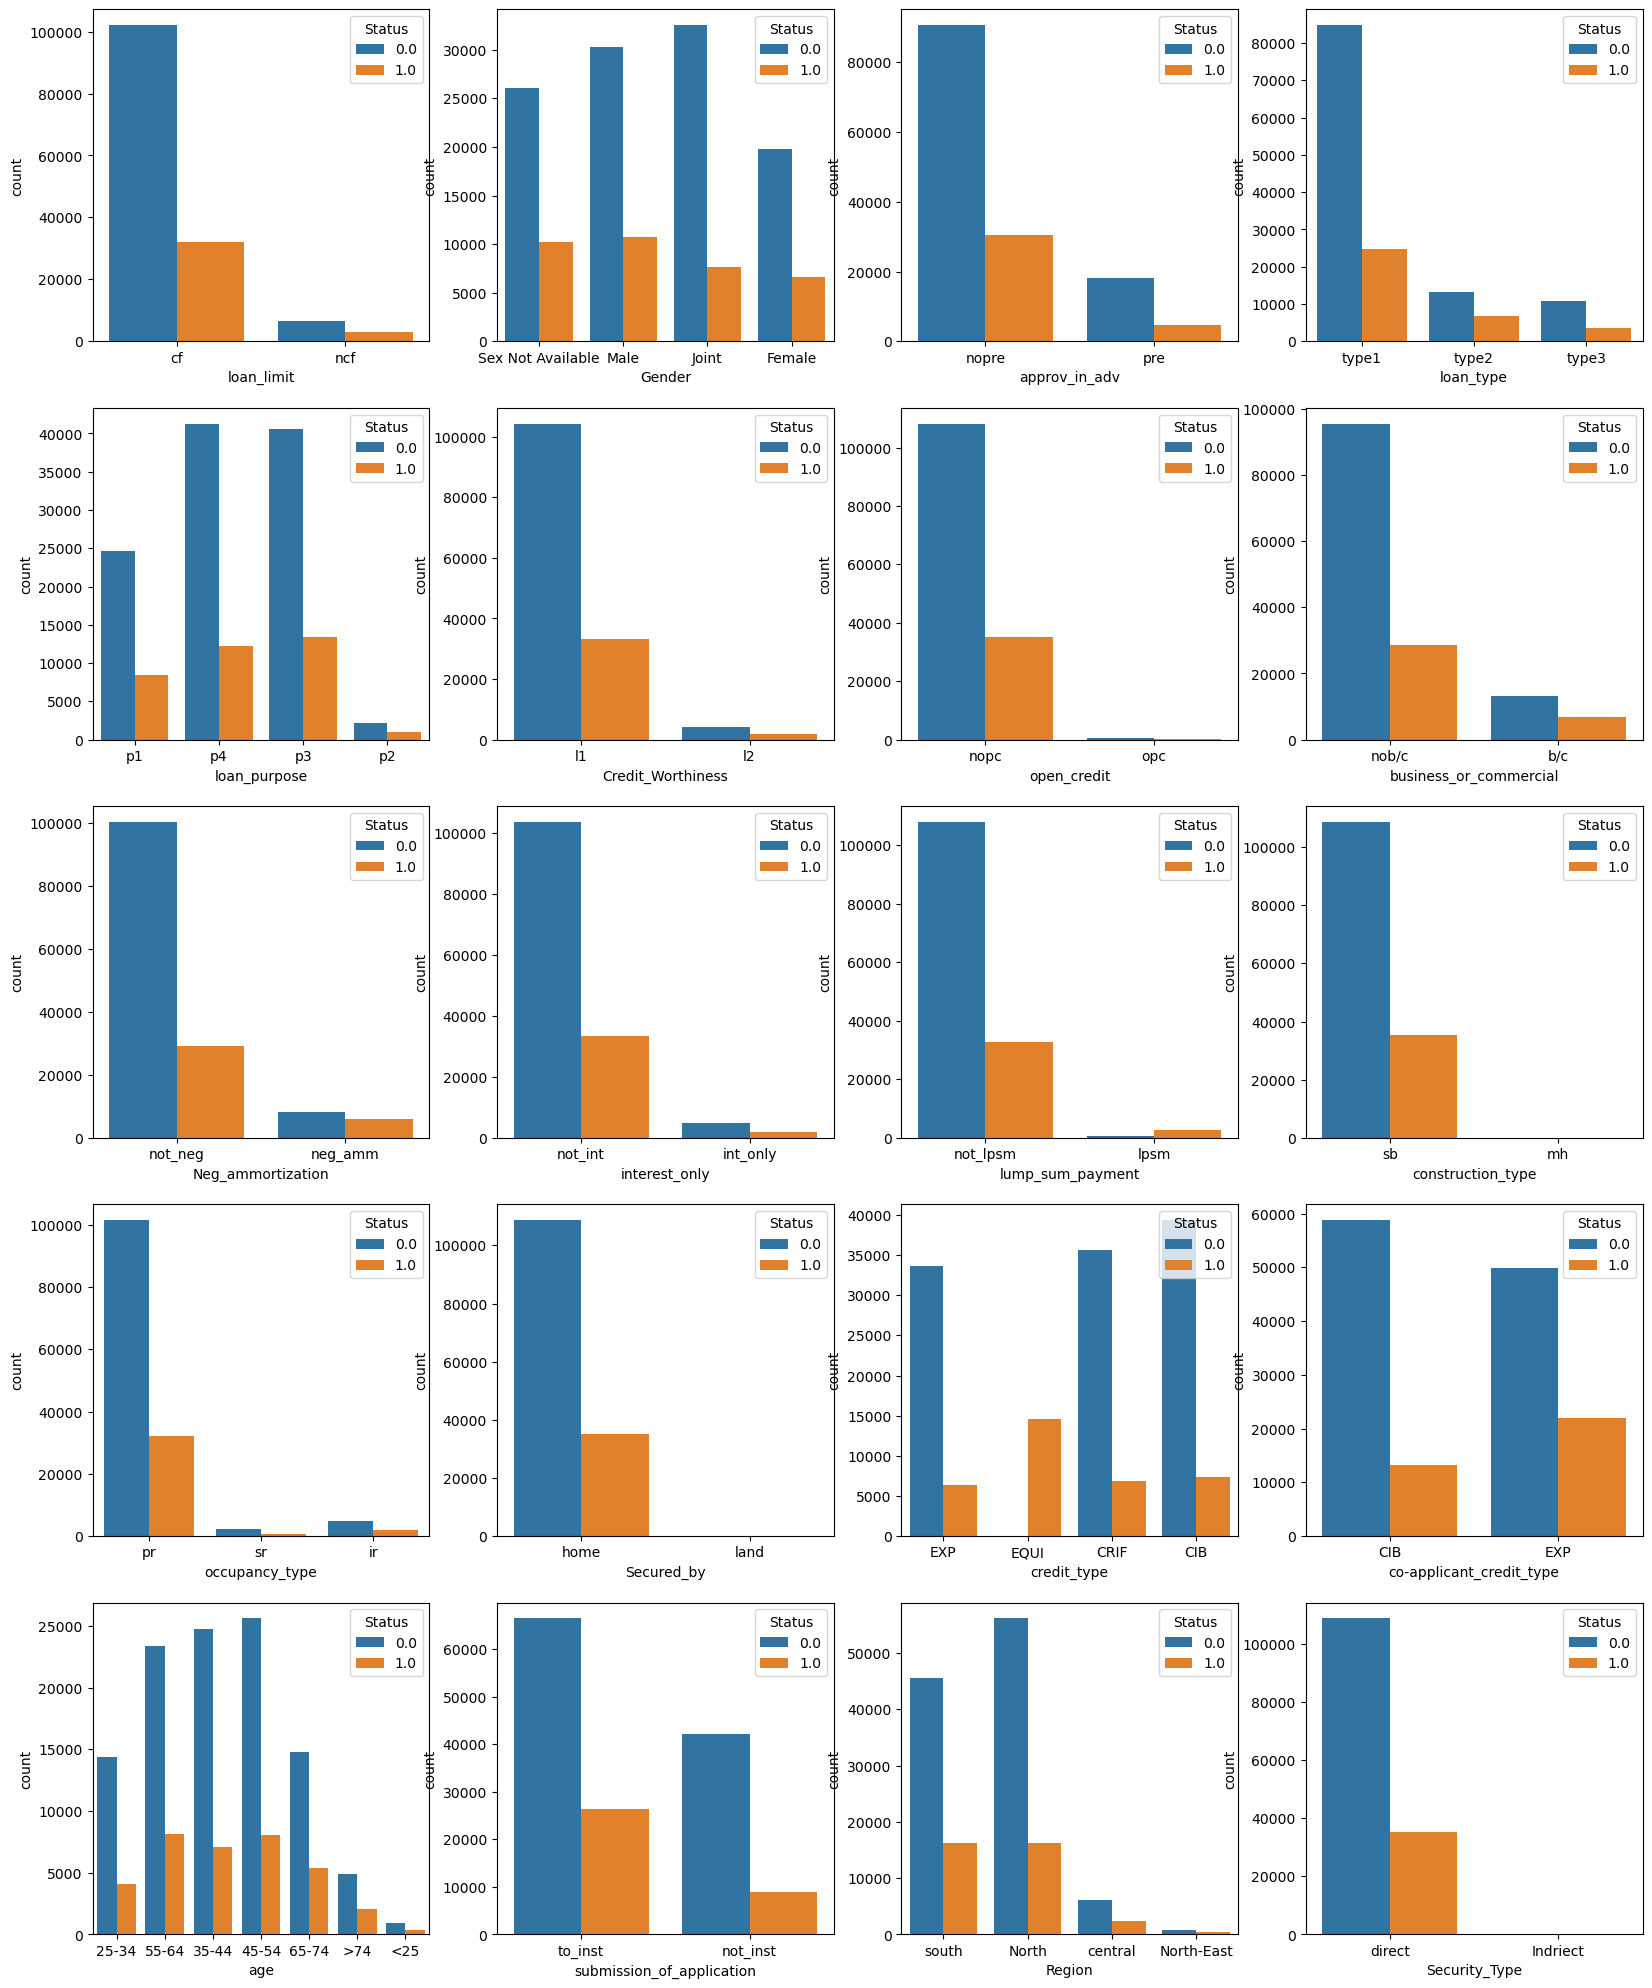

In [39]:
plt.figure(figsize=(20,25))

for i, col in enumerate(categorical_columns):
    plt.subplot(5,4,i+1)
    sns.countplot(data=df_fin,x=col,hue='Status')

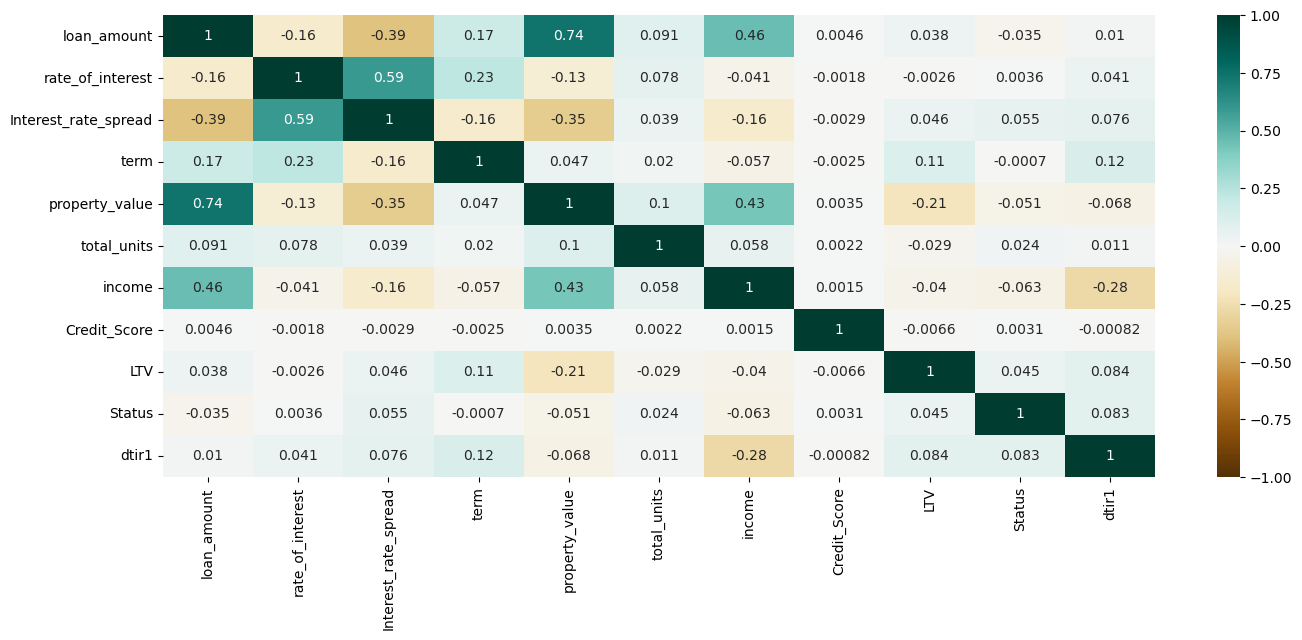

In [52]:
plt.figure(figsize=(16, 6))
sns.heatmap(df_fin[numerical_columns].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG');

loan_amount is significantly correlated with income and property value

interest_rate_spread is significantly correlated with rate_of_interest